# LLM Metrics Evaluation Demo
- This notebook demonstrates the complete workflow for evaluating generated text against reference text using 8 different metrics and applying thresholds.


### 1. Import Required Libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Add the parent directory to path if running from a subdirectory
sys.path.append('../..')

from llm_metrics import (
    BLEU, ROUGE, JSDivergence, BERTScore,
    JaccardSimilarity, CosineSimilarity, 
    LevenshteinDistance, SequenceMatcherSimilarity,
    apply_thresholds, generate_deltas_csv,
    get_default_thresholds, calculate_pass_fail_percent,
    plot_metric_comparison, plot_radar_comparison,
    prepare_results_dataframe
)

print("Libraries imported successfully!")

Libraries imported successfully!


### 2. Initialize Metrics

In [2]:
# Initialize all metric instances
metrics = {
    "BLEU": BLEU(),
    "ROUGE": ROUGE(rouge_types=["rougeL"]),  # Using ROUGE-L for simplicity
    "JSD": JSDivergence(),
    "BERTScore": BERTScore(model_type="bert-base-uncased", output_val=["f1"]),
    "Jaccard": JaccardSimilarity(),
    "Cosine": CosineSimilarity(),
    "Levenshtein": LevenshteinDistance(),
    "SequenceMatcher": SequenceMatcherSimilarity()
}

print("Metrics initialized:")
for name in metrics.keys():
    print(f"  - {name}")

Metrics initialized:
  - BLEU
  - ROUGE
  - JSD
  - BERTScore
  - Jaccard
  - Cosine
  - Levenshtein
  - SequenceMatcher


### 3. Sample Data for the implementation

In [3]:
# Single pair example
single_generated = "The quick brown fox jumps over the lazy dog"
single_reference = "A quick brown fox jumped over a lazy dog"

# Batch examples - varying quality of translations/paraphrases
generated_texts = [
    # High quality paraphrases
    "The quick brown fox jumps over the lazy dog",
    "A beautiful sunset painted the sky with vibrant colors",
    "Machine learning models require large amounts of data",
    
    # Medium quality paraphrases
    "The cat sat on the comfortable mat",
    "Artificial intelligence is transforming many industries",
    
    # Lower quality / more different
    "Dogs are loyal companions",
    "Programming requires logical thinking",
    "The weather is nice today"
]

reference_texts = [
    # Corresponding references
    "A quick brown fox jumped over a lazy dog",
    "The sunset painted beautiful colors across the sky",
    "Machine learning algorithms need substantial data for training",
    
    "The cat was sitting on the mat",
    "AI technology is revolutionizing various sectors",
    
    "Cats make independent pets",
    "Coding needs systematic problem-solving skills",
    "It's a pleasant day outside"
]


### 4. Test Case-1: Single Pair Evaluation

In [4]:
print("=== SINGLE PAIR EVALUATION ===\n")

# Calculate scores for single pair
single_scores = {}
for name, metric in metrics.items():
    score = metric.calculate(single_generated, single_reference)
    single_scores[name] = score
    print(f"{name}: {score:.4f}" if isinstance(score, (int, float)) else f"{name}: {score}")

# Apply thresholds
print("\n--- Applying Default Thresholds ---")
default_thresholds = get_default_thresholds()
print("Default thresholds:", default_thresholds)

single_results = apply_thresholds(single_scores)

# Display results
print("\n--- Threshold Results ---")
for metric_name, details in single_results.items():
    print(f"\n{metric_name}:")
    print(f"  Score: {details['score']:.4f}" if isinstance(details['score'], (int, float)) else f"  Score: {details['score']}")
    print(f"  Threshold: {details['threshold_applied']}")
    print(f"  Passed: {details['passed_threshold']}")

=== SINGLE PAIR EVALUATION ===

BLEU: 0.1562
ROUGE: 0.7778
JSD: 0.5193
BERTScore: 0.9103
Jaccard: 0.6000
Cosine: 0.6838
Levenshtein: 0.8675
SequenceMatcher: 0.8675

--- Applying Default Thresholds ---
Default thresholds: {'BLEU': 0.5, 'ROUGE': 0.5, 'JSD': 0.5, 'BERTScore': 0.5, 'Jaccard': 0.5, 'Cosine': 0.5, 'Levenshtein': 0.5, 'SequenceMatcher': 0.5}

--- Threshold Results ---

BLEU:
  Score: 0.1562
  Threshold: 0.5
  Passed: False

ROUGE:
  Score: 0.7778
  Threshold: 0.5
  Passed: True

JSD:
  Score: 0.5193
  Threshold: 0.5
  Passed: False

BERTScore:
  Score: 0.9103
  Threshold: 0.5
  Passed: True

Jaccard:
  Score: 0.6000
  Threshold: 0.5
  Passed: True

Cosine:
  Score: 0.6838
  Threshold: 0.5
  Passed: True

Levenshtein:
  Score: 0.8675
  Threshold: 0.5
  Passed: True

SequenceMatcher:
  Score: 0.8675
  Threshold: 0.5
  Passed: True


### 5. Test Case-2: Batch Evaluation

In [5]:
print("\n=== BATCH EVALUATION ===\n")

# Calculate scores for batch
batch_scores = []
for i in range(len(generated_texts)):
    item_scores = {}
    for name, metric in metrics.items():
        item_scores[name] = metric.calculate(generated_texts[i], reference_texts[i])
    batch_scores.append(item_scores)

print(f"Calculated scores for {len(batch_scores)} text pairs")

# Apply thresholds to batch
batch_results = apply_thresholds(batch_scores)

# Display first few results
print("\n--- Sample Results (First 3 items) ---")
for i in range(min(3, len(batch_results))):
    print(f"\nItem {i}:")
    print(f"Generated: '{generated_texts[i][:50]}...'")
    print(f"Reference: '{reference_texts[i][:50]}...'")
    for metric_name, details in batch_results[i].items():
        score_str = f"{details['score']:.3f}" if isinstance(details['score'], (int, float)) else str(details['score'])
        passed = "✓" if details['passed_threshold'] else "✗"
        print(f"  {metric_name}: {score_str} {passed}")


=== BATCH EVALUATION ===

Calculated scores for 8 text pairs

--- Sample Results (First 3 items) ---

Item 0:
Generated: 'The quick brown fox jumps over the lazy dog...'
Reference: 'A quick brown fox jumped over a lazy dog...'
  BLEU: 0.156 ✗
  ROUGE: 0.778 ✓
  JSD: 0.519 ✗
  BERTScore: 0.910 ✓
  Jaccard: 0.600 ✓
  Cosine: 0.684 ✓
  Levenshtein: 0.867 ✓
  SequenceMatcher: 0.867 ✓

Item 1:
Generated: 'A beautiful sunset painted the sky with vibrant co...'
Reference: 'The sunset painted beautiful colors across the sky...'
  BLEU: 0.079 ✗
  ROUGE: 0.471 ✗
  JSD: 0.549 ✗
  BERTScore: 0.790 ✓
  Jaccard: 0.600 ✓
  Cosine: 0.783 ✓
  Levenshtein: 0.519 ✓
  SequenceMatcher: 0.462 ✗

Item 2:
Generated: 'Machine learning models require large amounts of d...'
Reference: 'Machine learning algorithms need substantial data ...'
  BLEU: 0.065 ✗
  ROUGE: 0.375 ✗
  JSD: 0.342 ✓
  BERTScore: 0.765 ✓
  Jaccard: 0.231 ✗
  Cosine: 0.375 ✗
  Levenshtein: 0.557 ✓
  SequenceMatcher: 0.522 ✓


### 6. Calculating Pass/Fail Percentages

In [6]:
print("\n=== PASS/FAIL STATISTICS ===\n")

# Extract scores in the format expected by calculate_pass_fail_percentages
scores_dict = {}
for metric_name in metrics.keys():
    scores_dict[metric_name] = [item[metric_name] for item in batch_scores]

# Calculate percentages
percentages = calculate_pass_fail_percent(scores_dict)

# Display results
print("Metric Performance Summary:")
print("-" * 60)
print(f"{'Metric':<15} {'Pass Rate':<12} {'Passed':<10} {'Failed':<10}")
print("-" * 60)

for metric, stats in percentages.items():
    print(f"{metric:<15} {stats['pass_percentage']:>6.1f}% {stats['total_passed']:>10} {stats['total_failed']:>10}")


=== PASS/FAIL STATISTICS ===

Metric Performance Summary:
------------------------------------------------------------
Metric          Pass Rate    Passed     Failed    
------------------------------------------------------------
BLEU               0.0%          0          8
ROUGE             25.0%          2          6
JSD               62.5%          5          3
BERTScore        100.0%          8          0
Jaccard           37.5%          3          5
Cosine            37.5%          3          5
Levenshtein       50.0%          4          4
SequenceMatcher   37.5%          3          5


### 7. Generating CSV report for the deltas

In [7]:
# Single pair CSV
generate_deltas_csv(
    single_results,
    generated_texts=single_generated,
    reference_texts=single_reference,
    output_csv_path="single_pair_analysis.csv"
)

# Batch CSV
generate_deltas_csv(
    batch_results,
    generated_texts=generated_texts,
    reference_texts=reference_texts,
    output_csv_path="batch_analysis.csv"
)

# Display a sample of the batch CSV
print("\nSample of batch analysis CSV:")
df = pd.read_csv("batch_analysis.csv")
print(df.head(3))

CSV report generated at: single_pair_analysis.csv
CSV report generated at: batch_analysis.csv

Sample of batch analysis CSV:
                                      generated_text  \
0        The quick brown fox jumps over the lazy dog   
1  A beautiful sunset painted the sky with vibran...   
2  Machine learning models require large amounts ...   

                                      reference_text  BLEU_score  BLEU_passed  \
0           A quick brown fox jumped over a lazy dog    0.156197        False   
1  The sunset painted beautiful colors across the...    0.079369        False   
2  Machine learning algorithms need substantial d...    0.065006        False   

   ROUGE_score  ROUGE_passed  JSD_score  JSD_passed  BERTScore_score  \
0     0.777778          True   0.519324       False         0.910302   
1     0.470588         False   0.549008       False         0.790195   
2     0.375000         False   0.341808        True         0.765008   

   BERTScore_passed  Jaccard_score  

### 8. Testing with custom Thresholds

In [8]:
# Defining custom thresholds
custom_thresholds = {
    "BLEU": 0.7,
    "ROUGE": 0.65,
    "JSD": 0.3,  # Lower is better for JSD
    "BERTScore": 0.85,
    "Jaccard": 0.7,
    "Cosine": 0.8,
    "Levenshtein": 0.7,
    "SequenceMatcher": 0.75
}

print("Custom (stricter) thresholds:")
for metric, threshold in custom_thresholds.items():
    print(f"  {metric}: {threshold}")

# Apply custom thresholds
custom_results = apply_thresholds(batch_scores, thresholds=custom_thresholds)

# Calculate new percentages
custom_percentages = calculate_pass_fail_percent(scores_dict, thresholds=custom_thresholds)

print("\n--- Comparison: Default vs Custom Thresholds ---")
print(f"{'Metric':<15} {'Default Pass %':<15} {'Custom Pass %':<15} {'Difference':<10}")
print("-" * 55)

for metric in metrics.keys():
    default_pass = percentages[metric]['pass_percentage']
    custom_pass = custom_percentages[metric]['pass_percentage']
    diff = custom_pass - default_pass
    print(f"{metric:<15} {default_pass:>13.1f}% {custom_pass:>13.1f}% {diff:>+9.1f}%")

# Generate CSV with custom thresholds
generate_deltas_csv(
    custom_results,
    generated_texts=generated_texts,
    reference_texts=reference_texts,
    output_csv_path="custom_threshold_analysis.csv"
)

Custom (stricter) thresholds:
  BLEU: 0.7
  ROUGE: 0.65
  JSD: 0.3
  BERTScore: 0.85
  Jaccard: 0.7
  Cosine: 0.8
  Levenshtein: 0.7
  SequenceMatcher: 0.75

--- Comparison: Default vs Custom Thresholds ---
Metric          Default Pass %  Custom Pass %   Difference
-------------------------------------------------------
BLEU                      0.0%           0.0%      +0.0%
ROUGE                    25.0%          25.0%      +0.0%
JSD                      62.5%         100.0%     +37.5%
BERTScore               100.0%          25.0%     -75.0%
Jaccard                  37.5%           0.0%     -37.5%
Cosine                   37.5%           0.0%     -37.5%
Levenshtein              50.0%          12.5%     -37.5%
SequenceMatcher          37.5%          12.5%     -25.0%
CSV report generated at: custom_threshold_analysis.csv


### 9. Visualize Results

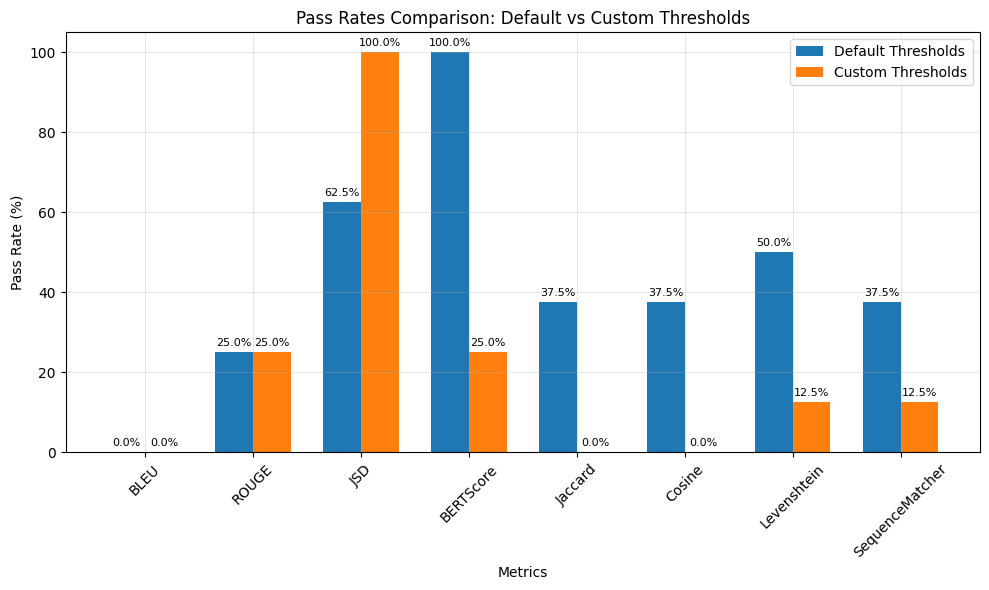

In [10]:
# Pass rates comparison plot
fig, ax = plt.subplots(figsize=(10, 6))

metrics_list = list(percentages.keys())
default_pass_rates = [percentages[m]['pass_percentage'] for m in metrics_list]
custom_pass_rates = [custom_percentages[m]['pass_percentage'] for m in metrics_list]

x = np.arange(len(metrics_list))
width = 0.35

bars1 = ax.bar(x - width/2, default_pass_rates, width, label='Default Thresholds')
bars2 = ax.bar(x + width/2, custom_pass_rates, width, label='Custom Thresholds')

ax.set_xlabel('Metrics')
ax.set_ylabel('Pass Rate (%)')
ax.set_title('Pass Rates Comparison: Default vs Custom Thresholds')
ax.set_xticks(x)
ax.set_xticklabels(metrics_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()